In [ ]:
#Mounting of google drive for project files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing major libraries and declaring some variables
import pandas as pd
import numpy as np
import os
import json
# Stuff for regex and embedding test later
import re
import operator
# Stuff for preparation of data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import Sequence
from keras.utils import plot_model
# Importing of model and model layers used
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dropout
from keras.models import Model
# Some other stuff for the model too
from keras.initializers import Constant
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from keras.metrics import Recall
# Experiments with plotting history
import matplotlib.pyplot as plt

# Some Variables Here
MAX_NUM_WORDS = 20000
MAX_REVSEQUENCE_LENGTH = 3000
# 20% of Data for Validation
VALIDATION_SPLIT = 0.2
# Embedding_Dim of 100 as we are using glove 100d
EMBEDDING_DIM = 100
# Main project path for later usage
projpath = "/content/drive/My Drive/Capstone Project"

In [ ]:
# Transferring Data from file in docked drive to dataframes

# Reading files to obtain data
print('Loading Data from File')
reviewspath = os.path.join(projpath,"IMDB_reviews.json")
review_df = pd.read_json(reviewspath, lines = True)

review_df = review_df[["review_text","is_spoiler","movie_id"]]
print('Data Loaded')
# Converting Spoiler Column to binary for later training
review_df["is_spoiler"] = review_df["is_spoiler"].astype(int)
print("Spoilers converted to binary")

# Getting the reviews as list
review_texts = review_df['review_text'].tolist()
review_texts = [x.lower() for x in review_texts]
print("Reviews column converted to list and lower-cased")

Loading Data from File
Data Loaded
Spoilers converted to binary
Reviews column converted to list and lower-cased
Synopsis column converted to list and lower-cased


In [ ]:
# Text Preprocessing

# Compiling the Regex for the replacement words
def get_replace(replace_dict):
    replace_re = re.compile('(%s)' % '|'.join(replace_dict.keys()))
    return replace_dict, replace_re

# Handling of hex strings and apostrophes
def advancedcleaning(text):
    text = re.sub('\x97', '', text)
    text = re.sub('\x96', '', text)
    text = re.sub('\x95', '', text)
    text = re.sub('\x85', '', text)
    text = re.sub('\xa0', '', text)
    text = re.sub("[^s]'[^s]", ' ', text)
    text = re.sub("'s", " 's", text)
    text = re.sub("s'", "s 's", text)
    return text

# Main Replace Function
def replace_list(textlist):
    def replace(match):
        return replacements[match.group(0)]
    cleanedwords = []
    for string in textlist:
        half_cleaned = replace_re.sub(replace,string)
        cleanedwords.append(advancedcleaning(half_cleaned))
    return cleanedwords

# Replacement Dictionary
# Expands most abbreviations found in the data
# Also replaces 2 misspellings that are not found in embedding
# Can be further refined to include more mispellings/alternative spellings
replace_dict = {"it´s":'it is', "it's":'it is', "he's":'he is',
                "let's":'let us', "she's":'she is', "who's":'who is',
                "that's":'that is', "what's":'what is', "here's":'here is',
                "there's":'there is',
                "i'm":'i am',
                "i've":'i have', "we've":'we have', "you've":'you have',
                "they've":'they have', "they've":'they have',
                "would've":'would have', "could've":'could have',
                "should've":'should have', "who've":'who have',
                "we're":'we are', "you're":'you are', "they're":'they are',
                "i'll":'i will', "it'll":'it will', "he'll":'he will',
                "we'll":'we will', "you'll":'you will', "they'll":'they will',
                "that'll":'that will',
                "i'd":'i had', "you'd":'you had', "he'd":'he had',
                "it'd":'it had', "we'd":'we had', "who'd":"who had",
                "they'd":'they had',
                "ain't":'am not', "don´t":'do not', "don't":'do not',
                "isn't":'is not', "can't":'cannot', "hadn't":'had not',
                "aren't":'are not', "didn't":'did not', "hasn't":'has not',
                "wasn't":'was not', "won't":'would not', "haven't":'have not',
                "weren't":'were not', "doesn´t":'does not',
                "doesn't":'does not', "couldn't":'could not',
                "wouldn't":'would not', "shouldn't":'should not',
                "singin'":"singing", 'bluray':'blu-ray'
                }

replacements, replace_re = get_replace(replace_dict)

# Preprocessing Lists of Reviews and Synopsis from earlier
# Takes approx. 6 Minutes with the tokenizer ltr
print("Preprocessing Texts")
review_texts = replace_list(review_texts)
print("Reviews Preprocessed")

# Training the keras tokenizer
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(review_texts)
print("Tokenizer Completed")

# Using the tokenizer to convert earlier list of Reviews and Synopsis into
# sequences
review_sequences = tokenizer.texts_to_sequences(review_texts)
print("Converted Reviews to sequences")

# Word_index for later usage
word_index = tokenizer.word_index

# Inserting the sequences into their various df and merging the 2 to create a
# central dataframe
maindf = review_df.assign(review_sequences = review_sequences)
maindf.drop(['movie_id'], axis=1, inplace = True)
maindf.head()


Preprocessing Texts
Reviews Preprocessed
Synopsis Preprocessed
Tokenizer Completed
Converted Reviews to sequences
Converted Synopsis to sequences


,review_text,is_spoiler,review_sequences,plot_synopsis,synopsis_sequences
0,"In its Oscar year, Shawshank Redemption (writt...",1,"[9, 89, 397, 230, 2145, 1773, 393, 2, 502, 34,...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[9, 18359, 1194, 8908, 857, 3287, 3, 8217, 9, ..."
1,The Shawshank Redemption is without a doubt on...,1,"[1, 2145, 1773, 5, 195, 3, 724, 29, 4, 1, 91, ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[9, 18359, 1194, 8908, 857, 3287, 3, 8217, 9, ..."
2,I believe that this film is the best story eve...,1,"[8, 264, 10, 11, 19, 5, 1, 94, 51, 133, 526, 2...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[9, 18359, 1194, 8908, 857, 3287, 3, 8217, 9, ..."
3,"**Yes, there are SPOILERS here**This film has ...",1,"[352, 38, 22, 907, 140, 11, 19, 40, 63, 144, 3...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[9, 18359, 1194, 8908, 857, 3287, 3, 8217, 9, ..."
4,At the heart of this extraordinary movie is a ...,1,"[32, 1, 372, 4, 11, 1953, 13, 5, 3, 334, 2, 13...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[9, 18359, 1194, 8908, 857, 3287, 3, 8217, 9, ..."


In [ ]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w+', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [ ]:
# Df for data
datadf = maindf.drop(['review_text'], axis = 1)
# Randomising rows in df
datadf = datadf.sample(frac=1).reset_index(drop=True)
datadf.head()

,is_spoiler,review_sequences,synopsis_sequences
0,1,"[8, 166, 8, 14, 143, 6, 108, 11, 13, 18, 6, 62...","[1, 19, 640, 16, 1, 2342, 4026, 3, 176, 56, 75..."
1,1,"[1136, 3423, 11, 13, 5, 29, 4, 1, 94, 8, 21, 1...","[7, 5, 4067, 3179, 922, 4835, 789, 1689, 7510,..."
2,0,"[11, 13, 14, 1, 94, 393, 992, 616, 14542, 531,...","[3, 628, 4, 5371, 86, 22, 587, 5767, 43, 261, ..."
3,0,"[502, 34, 1539, 5823, 1438, 863, 2087, 1120, 1...","[32, 1, 383, 4, 2114, 24, 3474, 1, 4330, 1219,..."
4,1,"[33, 672, 423, 1288, 2, 5950, 1046, 8168, 1, 5...",[]


In [ ]:
# Calculating number of Validation Samples
num_validation_samples = int(VALIDATION_SPLIT * len(datadf.index))
print("There are %s validation samples" % num_validation_samples)

trainingdf = datadf.loc[:(num_validation_samples - 1)]
validationdf = datadf.loc[num_validation_samples:]
labels_index = {"NotSpoiler" : 0, "Spoiler" : 1}
print ("Training and Validation DF prepared")
print(len(trainingdf.index))
print(len(validationdf.index))

There are 114781 validation samples
Training and Validation DF prepared
114781
459125


In [ ]:
# Building Embedding_Index(A dictionary) from file

glove_path = os.path.join(projpath, 'glove.6B.100d.txt')

# Function to build the dictionary
def build_embedding_index():
  embeddings_index = {}
  with open(glove_path, encoding = 'utf8') as f:
    for line in f:
      # Split the line up into the word and the coeff of word in glove file
      word, coefs = line.split(maxsplit=1)
      # Converts coeff into an nparray for future purposes
      coefs = np.fromstring(coefs, dtype = 'float', sep=' ')
      embeddings_index[word] = coefs
  return embeddings_index

embeddings_index = build_embedding_index()

print("Embedding Index dictionary has been consructed.")

print('Found %s word vectors.' % len(embeddings_index))

Embedding Index dictionary has been consructed.
Found 400000 word vectors.


In [ ]:
class ValidationDataGenerator(Sequence):
    # Generates Data
    def __init__(self, datadf, batch_size=128, n_classes=2, shuffle=True,
                 max_rev_seq_length=3000):
        # 'Initialization'
        self.batch_size = batch_size
        # Batch Size of Data
        self.datadf = datadf
        # DF of data
        self.n_classes = n_classes
        # I think this is the number of classes (2 in our case)
        self.shuffle = shuffle
        # Whether or not to shuffle the data every epoch (Default is Yes for good measure)
        self.max_rev_seq_length = max_rev_seq_length
        # For Max sequence length in padding
        self.on_epoch_end()
        # Calls the on _epoch_end function for some reason

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.datadf.index) / self.batch_size))

    def __getitem__(self, index):
        # 'Generate one batch of data'
        # Generate indexes of the batch (Slicing from the array)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs needed through slice of index ealier
        index_list = indexes.tolist()

        # Passes the list to data_generation
        X, y = self.__data_generation(index_list)

        return X, y

    def on_epoch_end(self):
        # Shuffling of data after every epoch if shuffle is called
        # Otherwise, it just calls self.indexes which is a 1D array of numbers, each representing a data set
        self.indexes = np.arange(len(self.datadf.index))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index_list_temp):
        # 'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        # Generate data
        tempdf = datadf.loc[index_list_temp]
        temp_review_sequences = tempdf['review_sequences'].tolist()
        y = tempdf['is_spoiler'].tolist()
        padded_rev_sequences = pad_sequences(temp_review_sequences, maxlen=self.max_rev_seq_length))
        
        return padded_rev_sequences, to_categorical(np.asarray(y), num_classes=self.n_classes)

In [ ]:
class TrainingDataGenerator(Sequence):
    # Generates Data
    def __init__(self, datadf, batch_size=128, n_classes=2, shuffle=True,
                 max_rev_seq_length=3000):
        # 'Initialization'
        self.batch_size = batch_size
        # Batch Size of Data
        self.datadf = datadf
        # DF of data
        self.n_classes = n_classes
        # I think this is the number of classes (2 in our case)
        self.shuffle = shuffle
        # Whether or not to shuffle the data every epoch (Default is Yes for good measure)
        self.max_rev_seq_length = max_rev_seq_length
        # For Max sequence length in padding
        self.on_epoch_end()
        # Calls the on _epoch_end function for some reason

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.datadf.index) / self.batch_size))

    def __getitem__(self, index):
        # 'Generate one batch of data'
        # Generate indexes of the batch (Slicing from the array)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs needed through slice of index ealier
        index_list = indexes.tolist()

        # Passes the list to data_generation
        X, y, z = self.__data_generation(index_list)

        return X, y, z

    def on_epoch_end(self):
        # Shuffling of data after every epoch if shuffle is called
        # Otherwise, it just calls self.indexes which is a 1D array of numbers, each representing a data set
        self.indexes = np.arange(len(self.datadf.index))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index_list_temp):
        # 'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        # Generate data
        tempdf = datadf.loc[index_list_temp]
        temp_review_sequences = tempdf['review_sequences'].tolist()
        y = tempdf['is_spoiler'].tolist()
        padded_rev_sequences = pad_sequences(temp_review_sequences, maxlen=self.max_rev_seq_length)
        sample_weights = class_weight.compute_sample_weight('balanced', y) 
        return padded_rev_sequences, to_categorical(np.asarray(y), num_classes=self.n_classes), sample_weights

In [ ]:
# Preperation of Embedding Matrix for Embedding Layer later 

#Selecting the smaller number between max number of words and word_index length
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# An ndarray of zeros to be filled in by later fnction
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
def build_embedding_matrix():
  for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
print('Building Embedding Matrix')
build_embedding_matrix()
print('Embedding Matrix Built')

Building Embedding Matrix
Embedding Matrix Built


In [ ]:
# Loading Embedding Matrix into an Embedding layer
# Trainable is False so as to keep the embeddings fixed
rev_embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_REVSEQUENCE_LENGTH,
                            trainable=False)
print("Embedding Layers Declared")

Embedding Layers Declared


In [ ]:
# Training of Model

# Declaration of a 1D Covnet with global maxpooling
RevInput = Input(shape=(MAX_REVSEQUENCE_LENGTH,), dtype='int32')
x = rev_embedding_layer(RevInput)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
z = Dense(128, activation='relu')(x)
z = Dropout(0.5)(z)
Preds = Dense(len(labels_index), activation='sigmoid')(z)

# Compiling the Model
model = Model(inputs=RevInput,
              outputs = Preds)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc', Recall()])

# Model Checkpoint
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.h5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')
params = {'batch_size': 128,
          'n_classes': len(labels_index),
          'shuffle': True,
          'max_rev_seq_length': MAX_REVSEQUENCE_LENGTH}

training_generator = TrainingDataGenerator(trainingdf, **params)
validation_generator = ValidationDataGenerator(validationdf, **params)

In [ ]:
# Training Model
history = model.fit(training_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[checkpoint],
                    use_multiprocessing	= True,
                    workers = 8)

Epoch 1/10000
896/896 [==============================] - 325s 363ms/step - loss: 0.6168 - acc: 0.6545 - recall_1: 0.6573 - val_loss: 0.6053 - val_acc: 0.6692 - val_recall_1: 0.6706

Epoch 00001: val_acc improved from -inf to 0.66919, saving model to weights.001-0.6692.h5
Epoch 2/10000
896/896 [==============================] - 315s 351ms/step - loss: 0.5724 - acc: 0.6991 - recall_1: 0.6991 - val_loss: 0.5789 - val_acc: 0.7049 - val_recall_1: 0.7032

Epoch 00002: val_acc improved from 0.66919 to 0.70492, saving model to weights.002-0.7049.h5
Epoch 3/10000
896/896 [==============================] - 314s 351ms/step - loss: 0.5527 - acc: 0.7092 - recall_1: 0.7086 - val_loss: 0.5100 - val_acc: 0.7538 - val_recall_1: 0.7526

Epoch 00003: val_acc improved from 0.70492 to 0.75375, saving model to weights.003-0.7538.h5
Epoch 4/10000
896/896 [==============================] - 314s 351ms/step - loss: 0.5345 - acc: 0.7207 - recall_1: 0.7205 - val_loss: 0.5254 - val_acc: 0.7220 - val_recall_1: 0.72

Process ForkPoolWorker-367:
Process ForkPoolWorker-366:
Process ForkPoolWorker-368:
Process ForkPoolWorker-362:
Process ForkPoolWorker-361:
Process ForkPoolWorker-357:
Process ForkPoolWorker-356:
Process ForkPoolWorker-363:
Process ForkPoolWorker-360:
Process ForkPoolWorker-358:
Process ForkPoolWorker-353:
Process ForkPoolWorker-354:
Process ForkPoolWorker-364:
Traceback (most recent call last):
Process ForkPoolWorker-355:
Process ForkPoolWorker-359:
Process ForkPoolWorker-365:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
Traceback

KeyboardInterrupt: ignored

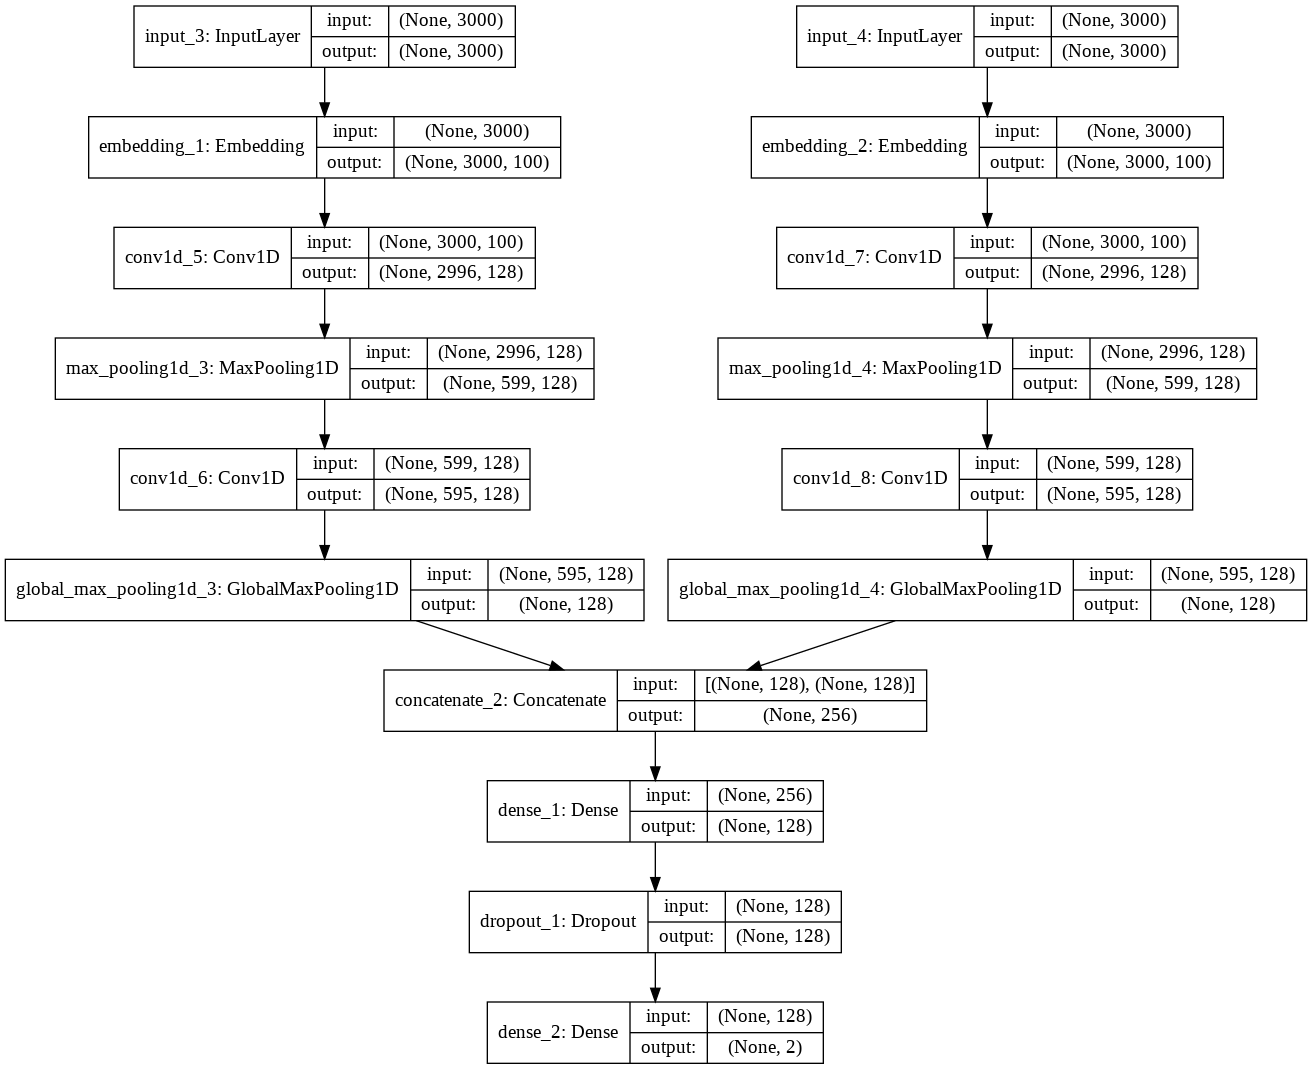

In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
)


In [ ]:
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()